## Install & import

In [1]:
!pip install casadi scipy tqdm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 MB 9.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from scipy.interpolate import interp1d
from numpy.linalg import svd
import casadi as ca
from concurrent.futures import ProcessPoolExecutor
import pandas as pd

## Model Definition

In [5]:
# === Model configuration ===
nx = 5
nth = 14
Tf = 161
Nt = 450
t_eval = np.linspace(0, Tf, Nt)

In [6]:
# === Load temperature data ===
data = loadmat('Operational_Data.mat')
TU = data['Time_Temp_Pairs']
TU[:, 1] += 273.15  # °C → K

In [7]:
# Symbolic variables for states and parameters
x = ca.MX.sym("x", nx)
theta = ca.MX.sym("theta", nth)
th = [theta[i] for i in range(nth)]
U1 = ca.MX.sym("U1")
U2 = ca.MX.sym("U2")

# === Model definition ===
xdot = ca.vertcat(
    th[0] * ca.exp(59453*(U1 - 300)/(300*8.314*U1)) * (x[1]/(x[1] + th[3] * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1)))) * x[0]
    - U2 * th[8] * ca.exp(0.0415 * x[4] + 130000*(U1 - 305.65)/(305.65*8.314*U1)) * x[0],
    -th[0] * ca.exp(59453*(U1 - 300)/(300*8.314*U1)) * (x[1]/(x[1] + th[3] * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1)))) * (x[0]/th[9]),
    -((th[0] * ca.exp(59453*(U1 - 300)/(300*8.314*U1)) * (x[1]/(x[1] + th[3] * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1)))) / th[10])
      + (th[1] * ca.exp(11000*(U1 - 296.15)/(296.15*8.314*U1)) * (x[2]/(x[2] + th[4] * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1))))
         * (th[7] * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1)) / (x[4] + th[7] * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1)))) / th[12])
      + 0.01 * ca.exp(37681*(U1 - 293.3)/(293.3*8.314*U1)) * (x[2]/(x[2] + x[3]))) * x[0],
    -((th[0] * ca.exp(59453*(U1 - 300)/(300*8.314*U1)) * (x[1]/(x[1] + th[3] * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1)))) / th[11])
      + (th[2] * ca.exp(11000*(U1 - 296.15)/(296.15*8.314*U1)) * (x[3]/(x[3] + th[5] * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1))))
         * (th[6] * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1)) / (x[2] + th[7] * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1))))
         * (th[7] * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1)) / (x[4] + th[7] * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1)))) / th[13])
      + 0.01 * ca.exp(37681*(U1 - 293.3)/(293.3*8.314*U1)) * (x[3]/(x[2] + x[3]))) * x[0],
    (th[1] * ca.exp(11000*(U1 - 296.15)/(296.15*8.314*U1)) * (x[2]/(x[2] + th[4] * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1))))
     * (th[7] * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1)) / (x[4] + th[7] * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1))))
     + th[2] * ca.exp(11000*(U1 - 296.15)/(296.15*8.314*U1)) * (x[3]/(x[3] + th[5] * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1))))
     * (th[6] * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1)) / (x[2] + th[7] * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1))))
     * (th[7] * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1)) / (x[4] + th[7] * ca.exp(46055*(U1 - 293.15)/(293.15*8.314*U1))))) * x[0]
)

# === Initial conditions (Zenteno et al. 2010) ===
x0_val = np.array([0.2, 0.1737, 115.55, 100.94, 0.0])
dx0_val = np.zeros((nx, nth))  # ∂x0/∂θ = 0

## Extended System

In [9]:
# === Symbolic derivatives for extended system ===
# These Jacobians define the structure of the sensitivity dynamics

dfdx = ca.jacobian(xdot, x)
dfdth = ca.jacobian(xdot, theta)

# === CasADi function wrappers ===
# These functions allow efficient numerical evaluation of the model and its derivatives

f_fun = ca.Function("f", [x, U1, U2, theta], [xdot])
dfdx_fun = ca.Function("dfdx", [x, U1, U2, theta], [dfdx])
dfdth_fun = ca.Function("dfdth", [x, U1, U2, theta], [dfdth])

# === Extended system: sensitivity ODEs ===
# Implements d(xθ)/dt = (∂f/∂x)·xθ + ∂f/∂θ
# Solves both the original system and the sensitivity dynamics

def meta_rhs(t, x_ext, TU, theta_val):
    X = x_ext[:nx]
    dx_dth = x_ext[nx:].reshape((nx, nth))
    interp_temp = interp1d(TU[:, 0], TU[:, 1], kind='nearest', fill_value="extrapolate")
    U1_val = float(interp_temp(t))
    Td = -0.0001 * X[4]**3 + 0.0049 * X[4]**2 - 0.1279 * X[4] + 315.89
    U2_val = 1.0 if U1_val >= Td else 0.0
    dx = np.array(f_fun(X, U1_val, U2_val, theta_val)).flatten()
    A = np.array(dfdx_fun(X, U1_val, U2_val, theta_val))
    B = np.array(dfdth_fun(X, U1_val, U2_val, theta_val))
    d_dx_dth = A @ dx_dth + B
    return np.concatenate([dx, d_dx_dth.flatten()])

# === Forward integration of state and sensitivities ===
# Solves the extended system using initial state and initial sensitivities

def simulate_once(theta_val, TU):
    x_ext0 = np.concatenate([x0_val, dx0_val.flatten()])
    sol = solve_ivp(
        lambda t, x: meta_rhs(t, x, TU, theta_val),
        (0, Tf),
        x_ext0,
        t_eval=t_eval,
        method="RK45",
        rtol=1e-8,
        atol=1e-8
    )
    x_out = sol.y[:nx, :].T
    dx_dth_out = sol.y[nx:, :].T.reshape(Nt, nx, nth)
    return x_out, dx_dth_out

# === Sensitivity matrix computation (output) ===
# Implements: yθ = (∂h/∂x)·xθ + ∂h/∂θ
# In this model, h(x) = x₁(t), so ∂h/∂x = [1, 0] and ∂h/∂θ = 0

def compute_dydth(x_out, dx_dth_out, theta_val, theta_nom):
    ny = 3
    dydth = np.zeros((Nt * ny, len(theta_val)))
    dydth_rel = np.zeros_like(dydth)
    y_out = np.zeros((Nt, ny))
    for i in range(Nt):
        y_out[i, 0] = x_out[i, 1]
        y_out[i, 1] = x_out[i, 2]
        y_out[i, 2] = x_out[i, 3]
        for j in range(ny):
            dydth[i * ny + j, :] = dx_dth_out[i, j + 1, :]
            if y_out[i, j] != 0:
                dydth_rel[i * ny + j, :] = dydth[i * ny + j, :] * theta_nom / y_out[i, j]
    return dydth, dydth_rel, y_out

## Monte Carlo

In [14]:
# === Monte Carlo sensitivity analysis ===
# Sample parameter vectors around the nominal values

NExp = 100
theta_nom = np.array([
    0.197199633268649,
    0.229613344074747,
    0.248791924669248,
    0.00964657420423634,
    8.55185355801220,
    7.16565013620336,
    44.1506697770253,
    42.5282844691618,
    0.00044,
    18.1864198172539,
    1.39311914120896,
    1.64263387274557,
    0.451745756284934,
    0.436908958787961
])
theta_low = 0.9 * theta_nom
theta_high = 1.1 * theta_nom
THETA = np.random.uniform(theta_low, theta_high, size=(NExp, nth))
THETA[0] = theta_nom

def montecarlo_worker(args):
    theta_k, TU_k, theta_nom_k = args
    x_out, dx_dth_out = simulate_once(theta_k, TU_k)
    dydth, dydth_rel, _ = compute_dydth(x_out, dx_dth_out, theta_k, theta_nom_k)
    _, S, Vh = svd(dydth_rel, full_matrices=False)
    return S, Vh[-1]

start_time = time.perf_counter()
with ProcessPoolExecutor() as executor:
    results = list(executor.map(
        montecarlo_worker,
        [(THETA[k], TU, theta_nom) for k in range(NExp)]
    ))
elapsed_time = time.perf_counter() - start_time
print(f"\nSimulation time (parallel): {elapsed_time:.3e} s.")

SingularValues = np.array([r[0] for r in results])
V_last_cols = np.array([r[1] for r in results]).T


Simulation time (parallel): 1.500e+03 s.


##Plot

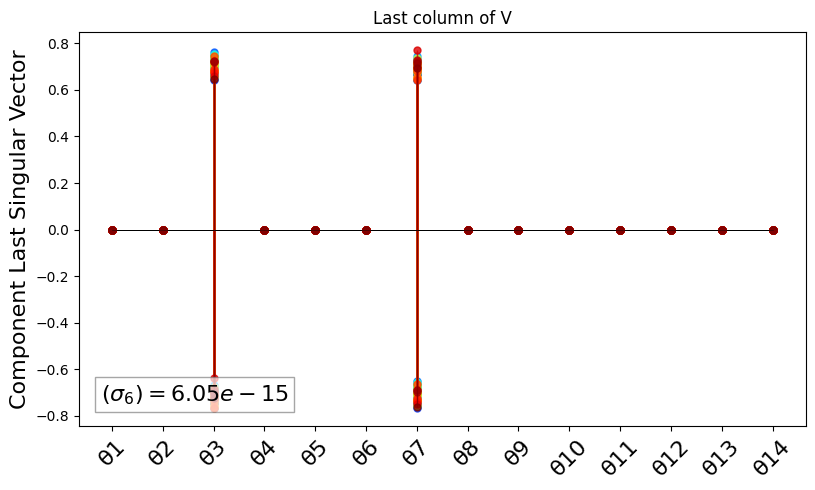

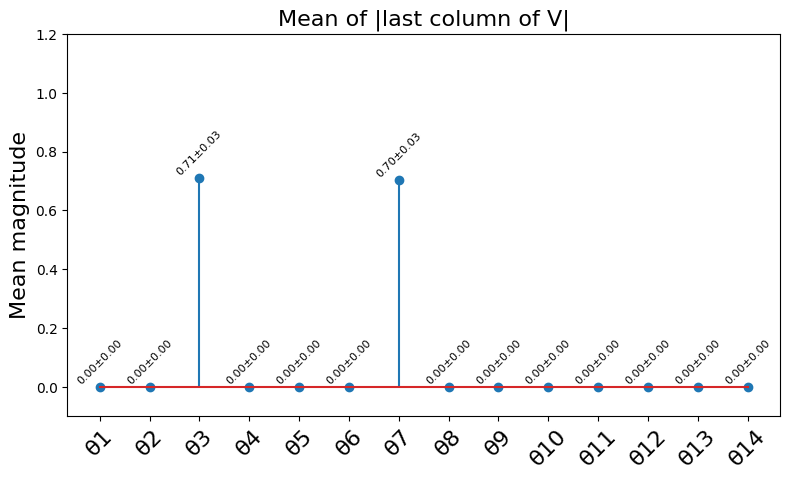

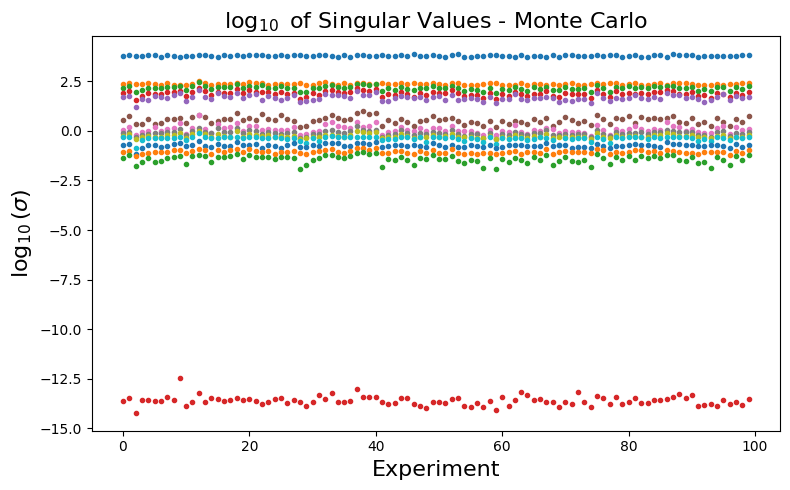

In [15]:
param_names = [f"θ{i+1}" for i in range(nth)]
mean_v = np.mean(np.abs(V_last_cols), axis=1)
std_v = np.std(np.abs(V_last_cols), axis=1)
min_sigma = np.min(SingularValues[:, -1])
max_sigma = np.max(SingularValues[:, 0])

plt.figure(figsize=(8, 5))
colors = plt.cm.jet(np.linspace(0, 1, NExp))
x_vals = np.arange(nth)
for k in range(NExp):
    y_vals = V_last_cols[:, k]
    markerline, stemlines, baseline = plt.stem(x_vals, y_vals, linefmt='-', markerfmt='o', basefmt='k-')
    plt.setp(markerline, color=colors[k], markersize=5, alpha=0.8)
    plt.setp(stemlines, color=colors[k], linewidth=1, alpha=0.8)
    plt.setp(baseline, color='k', linewidth=0.5, alpha=0.5)
plt.text(
    0.03, 0.05,
    r'$(\sigma_{\mathrm{6}})=%.2e$' % min_sigma,
    fontsize=16,
    transform=plt.gca().transAxes,
    ha='left', va='bottom',
    bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7)
)
plt.xticks(x_vals, param_names, rotation=45, fontsize=16)
plt.title(f"Last column of V")
plt.tight_layout()
plt.ylabel(r"Component Last Singular Vector", fontsize=16)
plt.show()

plt.figure(figsize=(8, 5))
plt.stem(mean_v)
plt.xticks(np.arange(nth), param_names, rotation=45, fontsize=16)
for i in range(nth):
    plt.text(i, mean_v[i] + 0.01, f"{mean_v[i]:.2f}±{std_v[i]:.2f}",
             ha='center', fontsize=8, rotation=45)
plt.title("Mean of |last column of V|", fontsize=16)
plt.ylabel("Mean magnitude", fontsize=16)
plt.tight_layout()
plt.ylim(-0.1, 1.2)
plt.show()

plt.figure(figsize=(8, 5))
for i in range(nth):
    plt.plot(np.log10(SingularValues[:, i]), '.', markersize=6)
plt.xlabel("Experiment", fontsize=16)
plt.ylabel(r"$\log_{10}(\sigma)$", fontsize=16)
plt.title(r"$\log_{10}$ of Singular Values - Monte Carlo", fontsize=16)
plt.tight_layout()
plt.show()

## Experimental data

In [16]:
# Read sheet “LAB-LO(02)” from the file that is already in the folder
df_exp = (
    pd.read_excel('Bioreactor 2020 - cinética fermentación.xlsx',
                  sheet_name='LAB-LO(02)')
      .dropna(subset=['Time (min)',
                      'Glucosa (g/L)',
                      'Fructosa (g/L)',
                      'YAN (mg/L)'])
)

# Convert columns to NumPy arrays (same pattern as with TU)
t_exp        = df_exp['Time (min)'].to_numpy(dtype=float) / 60.0   # min → h
glucosa_exp  = df_exp['Glucosa (g/L)'].to_numpy(dtype=float)
fructosa_exp = df_exp['Fructosa (g/L)'].to_numpy(dtype=float)
yan_exp      = df_exp['YAN (mg/L)'].to_numpy(dtype=float) / 1000.0 # mg/L → g/L

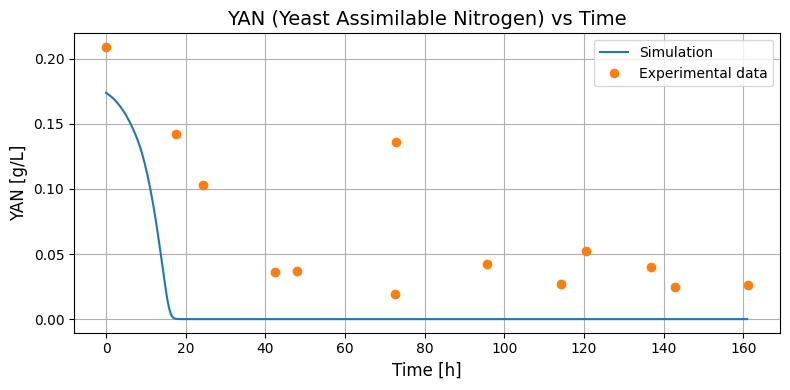

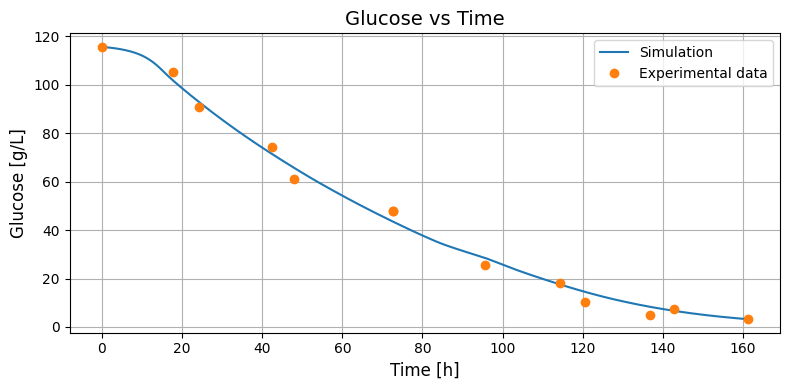

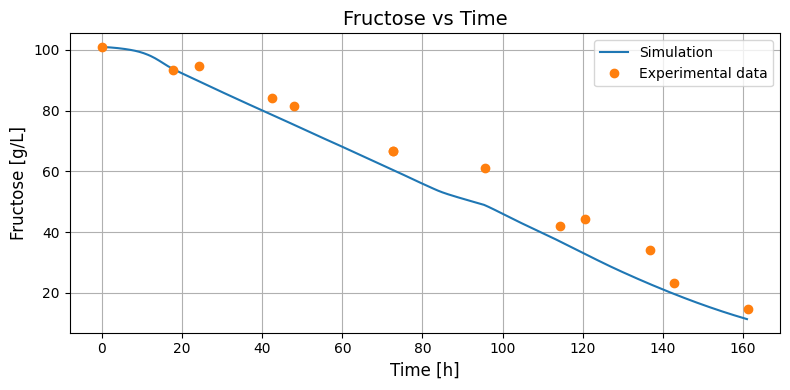

In [17]:
# === 1. Load experimental data ===

df_exp = (
    pd.read_excel('Bioreactor 2020 - cinética fermentación.xlsx',
                  sheet_name='LAB-LO(02)')
      .dropna(subset=['Time (min)', 'Glucosa (g/L)', 'Fructosa (g/L)', 'YAN (mg/L)'])
)

t_exp        = df_exp['Time (min)'].to_numpy(dtype=float) / 60.0   # min → hours
glucose_exp  = df_exp['Glucosa (g/L)'].to_numpy(dtype=float)
fructose_exp = df_exp['Fructosa (g/L)'].to_numpy(dtype=float)
yan_exp      = df_exp['YAN (mg/L)'].to_numpy(dtype=float) / 1000.0 # mg/L → g/L

# === 2. Simulate using nominal parameters ===
x_nom, dx_dth_nom = simulate_once(theta_nom, TU)
_, _, y_out = compute_dydth(x_nom, dx_dth_nom, theta_nom, theta_nom)

# === 3. Set up output mapping ===
outputs = {
    'YAN (Yeast Assimilable Nitrogen)': {
        'idx': 0,
        'exp': yan_exp,
        'ylabel': 'YAN [g/L]',
    },
    'Glucose': {
        'idx': 1,
        'exp': glucose_exp,
        'ylabel': 'Glucose [g/L]',
    },
    'Fructose': {
        'idx': 2,
        'exp': fructose_exp,
        'ylabel': 'Fructose [g/L]',
    }
}

# === 4. Plot simulation vs experimental data ===
import matplotlib.pyplot as plt

for name, info in outputs.items():
    i = info['idx']
    exp_data = info['exp']

    plt.figure(figsize=(8, 4))
    plt.plot(t_eval, y_out[:, i], label='Simulation', color='tab:blue')
    plt.plot(t_exp, exp_data, 'o', label='Experimental data', color='tab:orange')
    plt.xlabel('Time [h]', fontsize=12)
    plt.ylabel(info['ylabel'], fontsize=12)
    plt.title(f'{name} vs Time', fontsize=14)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
